### Car Fuel Consumption from Kaggle
## 検討目的：回帰によるconsumeの予測

In [83]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
# 以下，NNで追加
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
import tensorflow as tf

Since a few months, i write down the data of my car's display after each ride; while regularly changing the gas type.

|No.|data name|data explanation|
| :--- | :---: | ---: |
|1| distance | (km) |
|2| consume | consume(L/100km) |
|3| speed | the average speed(km/h) |
|4| temp_inside | the temprature inside(℃) |
|5| temp_outside | the temprature outside(℃) |
|6| specials | anything special |
|7| gas_type | the gas type i was using |
|8| AC | if the air contion was on |
|9| rain | if it was raining |
|10| sun | if it was sunny |
|11| refil l liters| how much I was buying |
|12| refil l gas| which gas type (SP98 in winter or E10 in spring )  I was buying |



# 1. データ読み込みと基礎統計量の確認

In [84]:
# ファイル読み込み
df_cp = pd.read_csv('../data/carfuel_consumption.csv')
df_cp.loc[100:110]

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
100,"5,3","4,1",34,NaN,9,NaN,SP98,0,0,0,NaN,NaN
101,"26,2","5,8",71,21,8,AC rain,SP98,1,1,0,NaN,NaN
102,"18,8",5,62,NaN,9,rain,SP98,0,1,0,NaN,NaN
103,"4,9","6,9",25,21,12,rain,SP98,0,1,0,NaN,NaN
104,"12,4","5,4",18,21,11,AC rain,SP98,1,1,0,NaN,NaN
105,"22,9","5,3",45,"20,5",7,NaN,SP98,0,0,0,NaN,NaN
106,"162,7","5,5",75,23,1,NaN,SP98,0,0,0,45,SP98
107,"4,9","6,5",26,21,1,NaN,SP98,0,0,0,NaN,NaN
108,"11,8","4,7",36,21,4,NaN,SP98,0,0,0,NaN,NaN
109,"16,6","5,1",56,21,7,NaN,SP98,0,0,0,NaN,NaN


In [85]:
df_cp.describe()

,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


In [86]:
# 数値の基礎情報の確認
df_cp.info()
# 加工用のデータセット作成　df_cp → df_cp2
df_cp2=df_cp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null object
consume          388 non-null object
speed            388 non-null int64
temp_inside      376 non-null object
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


# 2.前処理（説明変数の充実化）

In [87]:
#　文字データを数値データに変換
df_cp2['distance']=df_cp2['distance'].str.replace(',','.').astype(float)
df_cp2['consume']=df_cp2['consume'].str.replace(',','.').astype(float)
df_cp2['temp_inside']=df_cp2['temp_inside'].str.replace(',','.').astype(float)

#　refill liters，refill gas，specialsはデータ数が少ないため利用データから除外
df_cp2 = df_cp2.drop(['refill liters', 'refill gas'], axis=1)
df_cp2 = df_cp2.drop(['specials'], axis=1)

In [88]:
# 文字列データの内訳確認
df_cp2['gas_type'].unique()

array(['E10', 'SP98'], dtype=object)

In [89]:
#　文字列データの数値化
#　E10を0に，SP98を1に変換して，数値化
df_cp2['gas_type'] = df_cp2['gas_type'].str.replace('E10', '0').astype(str)
df_cp2['gas_type'] = df_cp2['gas_type'].str.replace('SP98', '1').astype(str)
df_cp2['gas_type'] = df_cp2['gas_type'].astype(int)

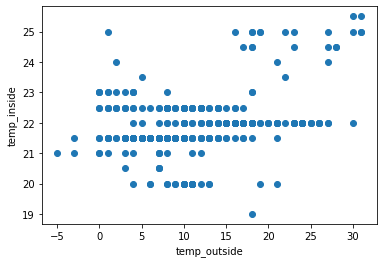

In [90]:
# temp_insideの欠測値の内挿
# 
yt = df_cp2['temp_inside'].values
xt = df_cp2['temp_outside'].values
plt.scatter(xt,yt)

plt.xlabel('temp_outside')
plt.ylabel('temp_inside')
plt.show()

#reg = LinearRegression(fit_intercept=True)
#reg.fit(Xt,yt)

In [91]:
# temp_insideの中央値で補完
df_cp2 = df_cp2.fillna({'temp_inside':df_cp2['temp_inside'].mean()})

In [92]:
#正規化処理
minmax = MinMaxScaler()
cp2 = minmax.fit_transform(df_cp2.values)

In [125]:
# ndarray形式をdataframe形式へ変換し，再度，columns付け
df_cp2 = pd.DataFrame(cp2)
df_cp2.columns = ['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'AC', 'rain', 'sun']

In [126]:
df_cp2.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,0.124302,0.191011,0.157895,0.384615,0.472222,0.0,0.0,0.0,0.0
1,0.049814,0.101124,0.210526,0.384615,0.500000,0.0,0.0,0.0,0.0
2,0.046089,0.247191,0.315789,0.384615,0.555556,0.0,0.0,0.0,0.0
3,0.054004,0.067416,0.289474,0.384615,0.527778,0.0,0.0,0.0,0.0
4,0.080074,0.134831,0.421053,0.384615,0.555556,0.0,0.0,0.0,0.0


# 3.前処理結果の概要確認

In [127]:
df_cp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null float64
temp_inside     388 non-null float64
temp_outside    388 non-null float64
gas_type        388 non-null float64
AC              388 non-null float64
rain            388 non-null float64
sun             388 non-null float64
dtypes: float64(9)
memory usage: 27.4 KB


In [128]:
df_cp2.describe()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,0.085442,0.181165,0.367472,0.450696,0.454396,0.587629,0.077320,0.123711,0.082474
std,0.105530,0.116087,0.178928,0.153026,0.194210,0.492897,0.267443,0.329677,0.275441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.048883,0.112360,0.246711,0.384615,0.333333,0.000000,0.000000,0.000000,0.000000
50%,0.061918,0.157303,0.348684,0.461538,0.416667,1.000000,0.000000,0.000000,0.000000
75%,0.082402,0.224719,0.473684,0.538462,0.583333,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
df_cp2.loc[100:110]

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
100,0.018622,0.089888,0.263158,0.450696,0.388889,1.0,0.0,0.0,0.0
101,0.115922,0.280899,0.750000,0.307692,0.361111,1.0,1.0,1.0,0.0
102,0.081471,0.191011,0.631579,0.450696,0.388889,1.0,0.0,1.0,0.0
103,0.016760,0.404494,0.144737,0.307692,0.472222,1.0,0.0,1.0,0.0
104,0.051676,0.235955,0.052632,0.307692,0.444444,1.0,1.0,1.0,0.0
105,0.100559,0.224719,0.407895,0.230769,0.333333,1.0,0.0,0.0,0.0
106,0.751397,0.247191,0.802632,0.615385,0.166667,1.0,0.0,0.0,0.0
107,0.016760,0.359551,0.157895,0.307692,0.166667,1.0,0.0,0.0,0.0
108,0.048883,0.157303,0.289474,0.307692,0.250000,1.0,0.0,0.0,0.0
109,0.071229,0.202247,0.552632,0.307692,0.333333,1.0,0.0,0.0,0.0


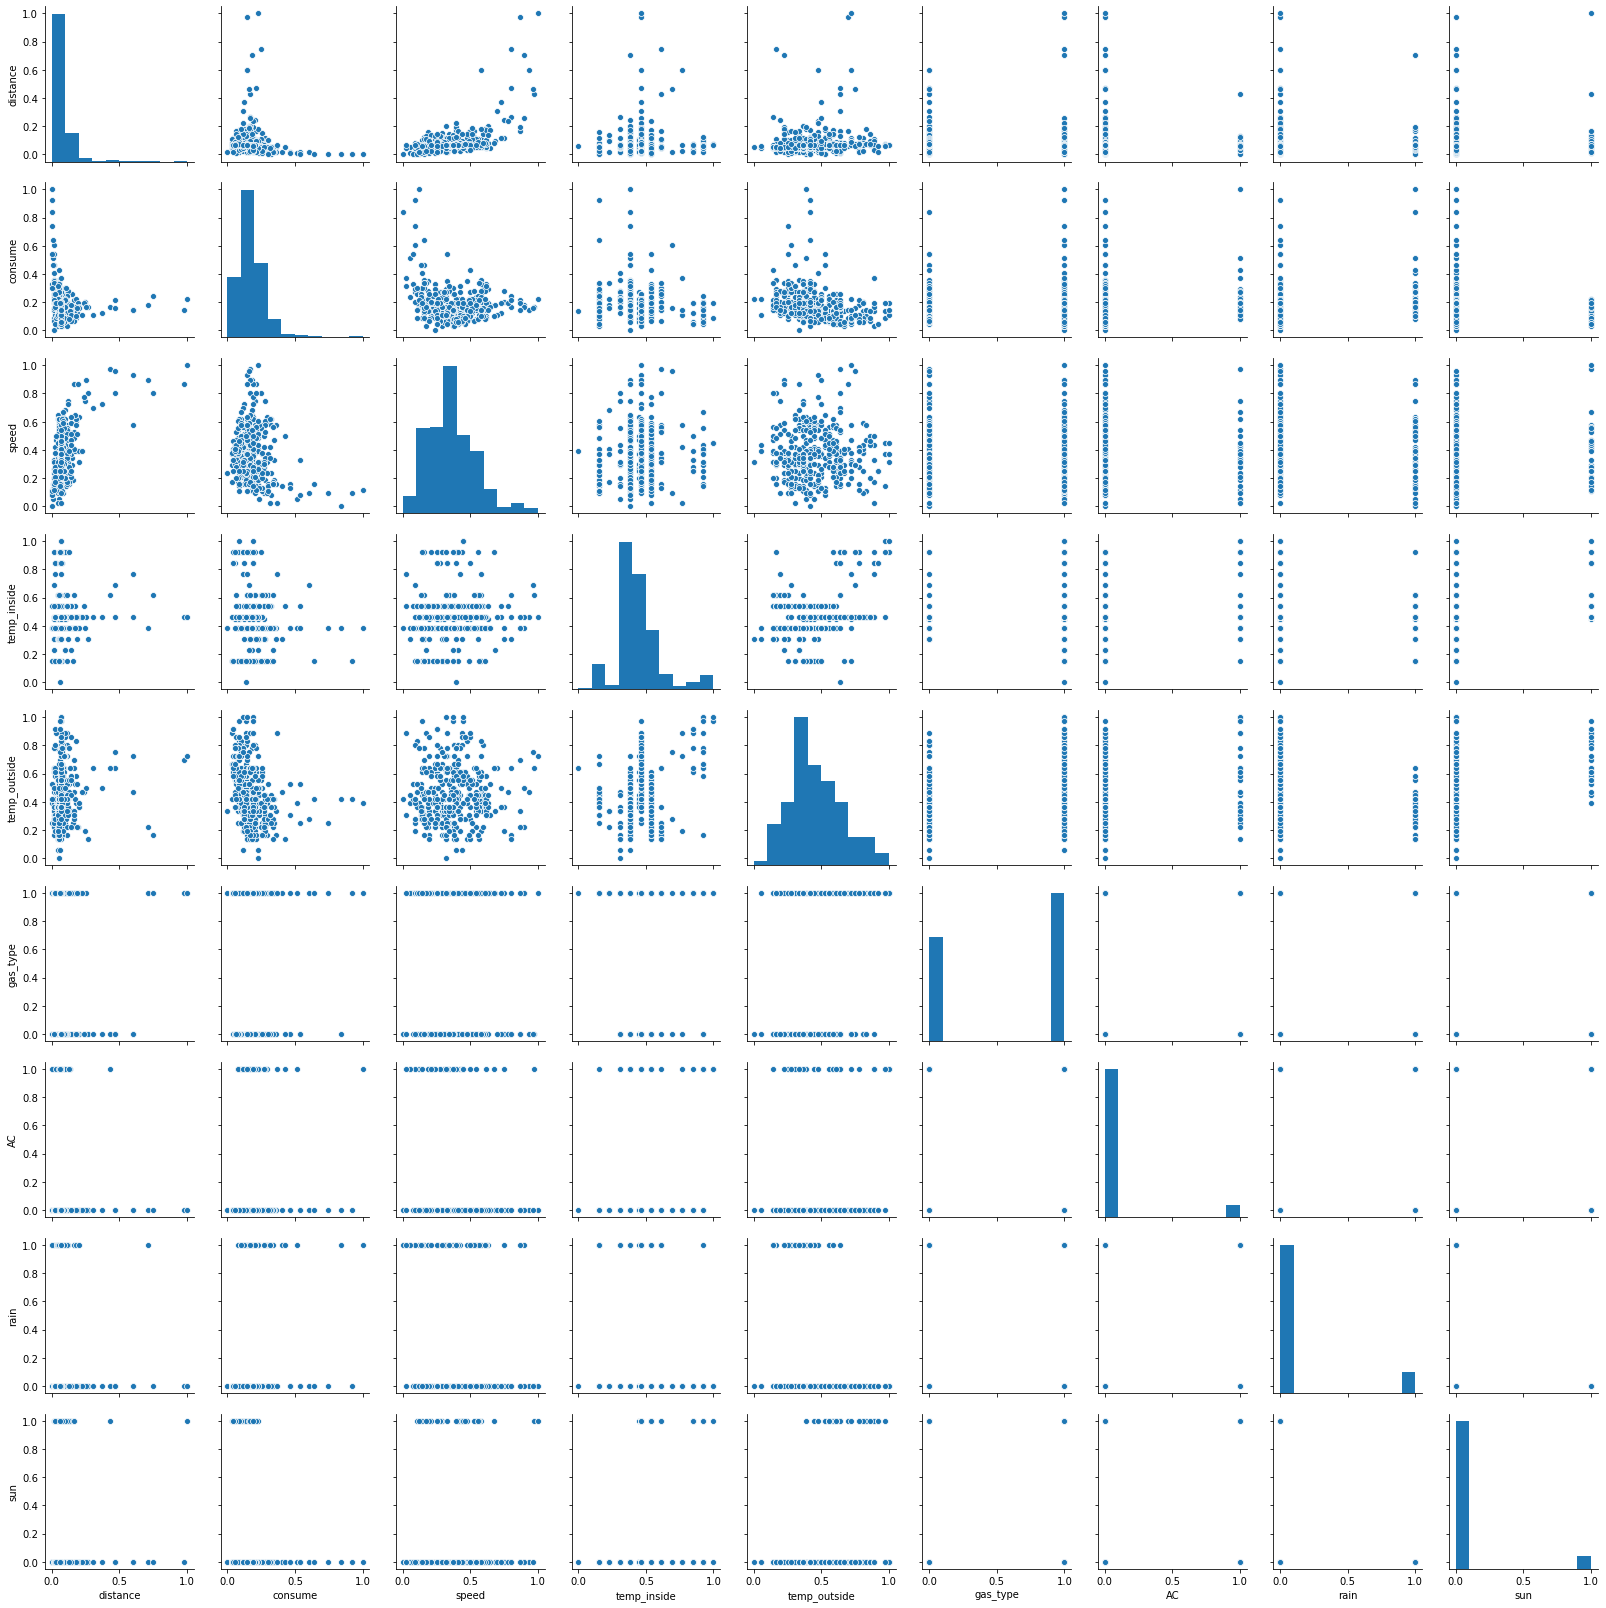

In [130]:
sns.pairplot(df_cp2)

# 4.目的変数と説明変数の設定

- 前回の検討にて説明変数が4変数よりも8変数の方がRMSEが小さくなったため8変数モデルを扱う

In [131]:
# consumeを目的変数に設定
y = df_cp2['consume'].values

# consume以外の8変数を説明変数に
X = df_cp2.drop(['consume'], axis=1).values

In [132]:
# 各変数の形状を確認
print(y.shape, X.shape)

(388,) (388, 8)


# 5.ホールドアウト法による線形近似

In [133]:
#X = x1.reshape(-1,1) # scikit-learnに入力するために整形

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

- `X_train` : 学習用データの説明変数
- `X_test` : テスト用データの説明変数
- `y_train` : 学習用データの目的変数
- `y_test` : テスト用データの目的変数

In [134]:
# 線形モデル作成
# 説明変数が8個
reg1 = LinearRegression(fit_intercept=True)
reg1.fit(X_train, y_train)

LinearRegression()

In [135]:
# 学習用データに対する予測を実行
y_pred_train = reg1.predict(X_train)

# 学習データに対する指標を計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

# 平均絶対誤差
print("MAE = %s"%round(mae,3) )
# 平均二乗誤差
print("MSE = %s"%round(mse,3) )
# 二乗平均平方根誤差
print("RMSE = %s"%round(rmse,3))
# 決定係数
print("R2 = %s"%round(r2,3))

MAE = 0.069
MSE = 0.011
RMSE = 0.106
R2 = 0.23


In [136]:
# テストデータに対する予測を実行
y_pred_test = reg1.predict(X_test)

# テストデータに対する指標を計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# 平均絶対誤差
print("MAE = %s"%round(mae,3) )
# 平均二乗誤差
print("MSE = %s"%round(mse,3) )
# 二乗平均平方根誤差
print("RMSE = %s"%round(rmse,3))
# 決定係数
print("R2 = %s"%round(r2,3))

MAE = 0.075
MSE = 0.009
RMSE = 0.092
R2 = 0.23


Text(0, 0.5, 'prediction')

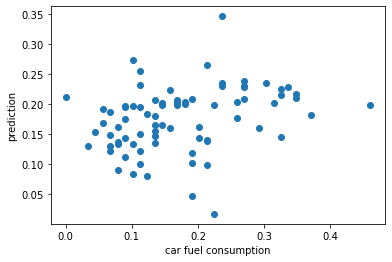

In [137]:
# 予測と実測の誤差を視覚化
plt.scatter(y_test, y_pred_test)
plt.xlabel('car fuel consumption')
plt.ylabel('prediction')

In [138]:
# 線形近似曲線のパラメータ算定
b = reg1.intercept_
w1 = reg1.coef_[0]
w2 = reg1.coef_[1]
w3 = reg1.coef_[2]
w4 = reg1.coef_[3]
w5 = reg1.coef_[4]
w6 = reg1.coef_[5]
w7 = reg1.coef_[6]
w8 = reg1.coef_[7]
print('b={:3f}, W1={:3f}, W2={:3f}, W3={:3f}, W4={:3f}, W5={:3f}, W6={:3f}, W7={:3f}, W8={:3f}'.format(b, w1,w2,w3,w4,w5,w6,w7,w8))

b=0.340580, W1=0.021188, W2=-0.166394, W3=-0.070401, W4=-0.160620, W5=-0.008557, W6=0.049874, W7=0.064884, W8=-0.021128


# 6.クロスバリデーション法による線形近似

In [139]:
#X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
cross_valid_mse = 0
cross_valid_rmse = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    reg2 = LinearRegression(fit_intercept=True)
    reg2.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = reg2.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    
    print("Fold %s"%split_num)
    # 平均絶対誤差
    print("MAE = %s"%round(mae,3) )
    # 平均二乗誤差
    print("MSE = %s"%round(mse,3) )
    # 二乗平均平方根誤差
    print("RMSE = %s"%round(rmse,3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    cross_valid_mse += mse #後で平均を取るためにMSEを加算
    cross_valid_rmse += rmse #後で平均を取るためにRMSEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))
# MSEの平均値を最終的な汎化誤差値とする
final_mse = cross_valid_mse / n_split
print("Cross Validation MSE = %s"%round(final_mse, 3))
# RMSEの平均値を最終的な汎化誤差値とする
final_rmse = cross_valid_rmse / n_split
print("Cross Validation RMSE = %s"%round(final_rmse, 3))

Fold 1
MAE = 0.075
MSE = 0.009
RMSE = 0.092

Fold 2
MAE = 0.07
MSE = 0.009
RMSE = 0.096

Fold 3
MAE = 0.083
MSE = 0.02
RMSE = 0.141

Fold 4
MAE = 0.069
MSE = 0.011
RMSE = 0.107

Fold 5
MAE = 0.058
MSE = 0.007
RMSE = 0.084

Cross Validation MAE = 0.071
Cross Validation MSE = 0.011
Cross Validation RMSE = 0.104


Text(0, 0.5, 'prediction')

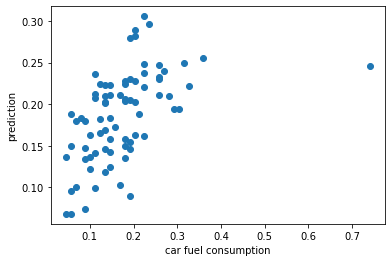

In [140]:
# 予測と実測の誤差を視覚化
# Fold5の予測値を利用
plt.scatter(y_test, y_pred_test)
plt.xlabel('car fuel consumption')
plt.ylabel('prediction')

In [141]:
# 線形近似曲線のパラメータ算定
# crossvalidationで最も指標が小さくなった最終foldout(Fold 5)からパラメータを持ってくる
b = reg2.intercept_
w1 = reg2.coef_[0]
w2 = reg2.coef_[1]
w3 = reg2.coef_[2]
w4 = reg2.coef_[3]
w5 = reg2.coef_[4]
w6 = reg2.coef_[5]
w7 = reg2.coef_[6]
w8 = reg2.coef_[7]
print('b={:3f}, W1={:3f}, W2={:3f}, W3={:3f}, W4={:3f}, W5={:3f}, W6={:3f}, W7={:3f}, W8={:3f}'.format(b, w1,w2,w3,w4,w5,w6,w7,w8))

b=0.332887, W1=0.058711, W2=-0.155516, W3=-0.076154, W4=-0.154482, W5=-0.005051, W6=0.057626, W7=0.060822, W8=-0.018149


# 7.NNによる線形近似

- ニューラルネットワークモデル条件の設定

In [200]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=8))
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(3, activation='relu', input_dim=5))
model.add(Dense(1, activation='linear'))

# ------ 最適化手法 ------
sgd = SGD(lr=0.001, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='mse',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

- trainデータとtestデータ作成
- その後，モデル計算

In [201]:
# ホールドアウト法でtrain,testデータを分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# データ形状確認
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (310, 8)
y_train: (310,)
X_test: (78, 8)
y_test: (78,)


Train on 310 samples, validate on 78 samples
Epoch 1/500
310/310 [==============================] - 0s 463us/sample - loss: 0.1512 - acc: 0.0000e+00 - val_loss: 0.0962 - val_acc: 0.0128
Epoch 2/500
310/310 [==============================] - 0s 58us/sample - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0285 - val_acc: 0.0128
Epoch 3/500
310/310 [==============================] - 0s 58us/sample - loss: 0.0224 - acc: 0.0000e+00 - val_loss: 0.0127 - val_acc: 0.0128
Epoch 4/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0152 - acc: 0.0000e+00 - val_loss: 0.0099 - val_acc: 0.0128
Epoch 5/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0140 - acc: 0.0000e+00 - val_loss: 0.0093 - val_acc: 0.0128
Epoch 6/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0137 - acc: 0.0000e+00 - val_loss: 0.0092 - val_acc: 0.0128
Epoch 7/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0137 - acc: 0.0000e+00 - val_loss:

Epoch 59/500
310/310 [==============================] - 0s 55us/sample - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 60/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 61/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 62/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 63/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 64/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0130 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 65/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0130 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 66/500


Epoch 117/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0126 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 118/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0126 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 119/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0126 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 120/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0126 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 121/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0126 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 122/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0126 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 123/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0126 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 

Epoch 175/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 176/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 177/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 178/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 179/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 180/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 181/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 

Epoch 233/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 234/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 235/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 236/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 237/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 238/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 239/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0128
Epoch 

Epoch 291/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 292/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 293/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 294/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 295/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 296/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 297/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0128
Epoch 

310/310 [==============================] - 0s 48us/sample - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0128
Epoch 349/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0128
Epoch 350/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0128
Epoch 351/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0128
Epoch 352/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0128
Epoch 353/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0128
Epoch 354/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0128
Epoch 355/500
310/31

Epoch 406/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 407/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 408/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 409/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 410/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 411/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 412/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0128
Epoch 

Epoch 464/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0113 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0128
Epoch 465/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0113 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0128
Epoch 466/500
310/310 [==============================] - 0s 51us/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0128
Epoch 467/500
310/310 [==============================] - 0s 52us/sample - loss: 0.0113 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0128
Epoch 468/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0113 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0128
Epoch 469/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0128
Epoch 470/500
310/310 [==============================] - 0s 48us/sample - loss: 0.0113 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0128
Epoch 

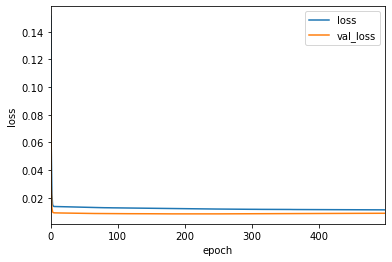

In [202]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=500,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [204]:
# テストデータに対する予測を実行
y_pred_test = model.predict(X_test)

# テストデータに対する指標を計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# 平均絶対誤差
print("MAE = %s"%round(mae,3) )
# 平均二乗誤差
print("MSE = %s"%round(mse,3) )
# 二乗平均平方根誤差
print("RMSE = %s"%round(rmse,3))
# 決定係数
print("R2 = %s"%round(r2,3))

MAE = 0.078
MSE = 0.009
RMSE = 0.094
R2 = 0.23


Text(0, 0.5, 'prediction')

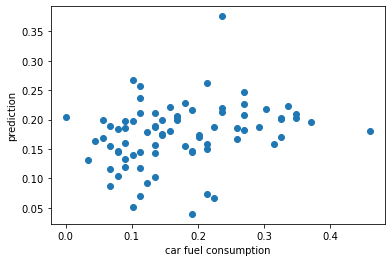

In [205]:
# 予測と実測の誤差を視覚化
plt.scatter(y_test, y_pred_test)
plt.xlabel('car fuel consumption')
plt.ylabel('prediction')